In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# This Sampling is used for sampling the z distribution
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# Loading the Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
MNIST_fashion = np.concatenate([x_train, x_test], axis=0)
MNIST_fashion = np.expand_dims(MNIST_fashion, -1).astype("float32") / 255
    
# Dimension of the encoder Output
z_vectorDim = 2

# Encoder :
# =========

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 14, activation="relu")(encoder_inputs)
x = layers.Conv2D(64, 6, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(168, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(z_vectorDim, name="z_mean")(x)
z_log_var = layers.Dense(z_vectorDim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
print(encoder.summary())

# Decoder :
# =========
latent_inputs = keras.Input(shape=(z_vectorDim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
print(decoder.summary())

# Defining the VAE from the keras.Model Class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.total_loss = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss,
            self.reconstruction_loss,
            self.kl_loss,
        ]

    # Defining the Regression Steps
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # Adding both the loss from the encoder and the decoder
            total_loss = reconstruction_loss + kl_loss
            
        # Applying gradient descent
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss.update_state(total_loss)
        self.reconstruction_loss.update_state(reconstruction_loss)
        self.kl_loss.update_state(kl_loss)
        return {
            "loss": self.total_loss.result(),
            "reconstruction loss": self.reconstruction_loss.result(),
            "kl loss": self.kl_loss.result(),
        }


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 15, 32)   6304        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 64)   73792       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 6400)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [3]:

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(MNIST_fashion, epochs=5, batch_size=128) # Epoch 10 is more than enough

Epoch 1/5
547/547 [==============================] - 21s 23ms/step - loss: 376.3511 - reconstruction loss: 371.9246 - kl loss: 4.4266
Epoch 2/5
547/547 [==============================] - 12s 22ms/step - loss: 276.8602 - reconstruction loss: 269.8200 - kl loss: 7.0402
Epoch 3/5
547/547 [==============================] - 12s 22ms/step - loss: 270.7230 - reconstruction loss: 264.1404 - kl loss: 6.5827
Epoch 4/5
547/547 [==============================] - 12s 22ms/step - loss: 267.5018 - reconstruction loss: 261.0626 - kl loss: 6.4392
Epoch 5/5
547/547 [==============================] - 12s 22ms/step - loss: 265.0528 - reconstruction loss: 258.6270 - kl loss: 6.4258


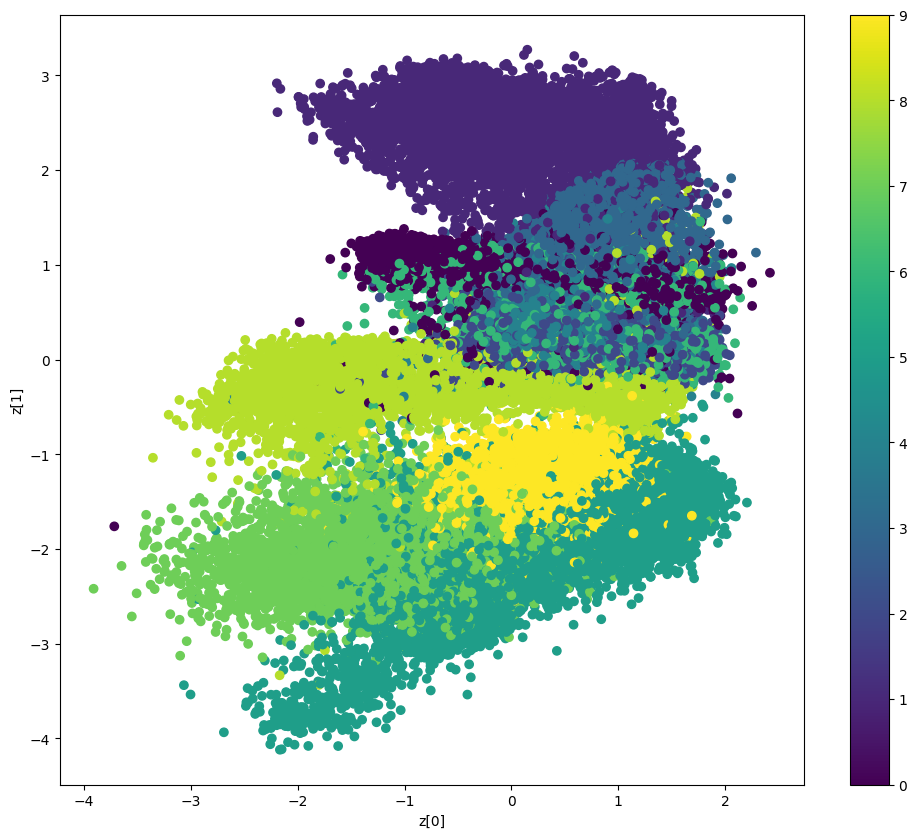

In [4]:
#%%
import matplotlib.pyplot as plt

# Displaying the z-subspace
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)



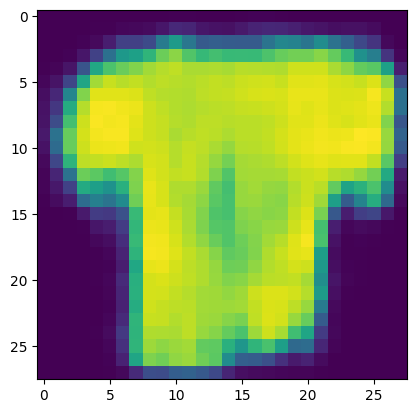

In [5]:
#%% Sampling a random vector in the given distribution

vector = np.array([[-2,1]])
picture = vae.decoder(vector)
newpic = np.reshape(picture[0], [28, 28])
plt.imshow(newpic)

In [6]:
#%% Mixing Images

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()

"""
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
"""

# Creating Average vectors from classes
selected_label_1 = 7
selected_label_2 = 8

selected_images_1 = []
selected_images_2 = []

for i in range(len(y_train)):
    if y_train[i] == selected_label_1:
        selected_images_1.append(x_train[i])
    if y_train[i] == selected_label_2:
        selected_images_2.append(x_train[i])
        
selected_images_1 = np.expand_dims(selected_images_1, -1).astype("float32") / 255
selected_images_2 = np.expand_dims(selected_images_2, -1).astype("float32") / 255
        
z_mean_1, z_log_var, z1 = vae.encoder(selected_images_1)
z_mean_2, z_log_var, z2 = vae.encoder(selected_images_2)

print(z_mean_1.shape)
print(z_mean_2.shape)

AverageZ1 = np.array([[np.mean(z1[:, 0]), np.mean(z1[:,1])]])
AverageZ2 = np.array([[np.mean(z2[:, 0]), np.mean(z2[:,1])]])

print(AverageZ1)




(6000, 2)
(6000, 2)
[[-1.1285319 -1.9526289]]


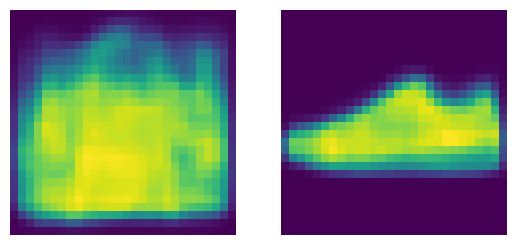

In [7]:
#%% Ploting the result of the two average images

plt.subplot(1,2,1)

picture = vae.decoder(AverageZ2)
newpic = np.reshape(picture[0], [28, 28])
plt.axis('off')
plt.imshow(newpic)

plt.subplot(1,2,2)

picture = vae.decoder(AverageZ1)
newpic = np.reshape(picture[0], [28, 28])
plt.axis('off')
plt.imshow(newpic)

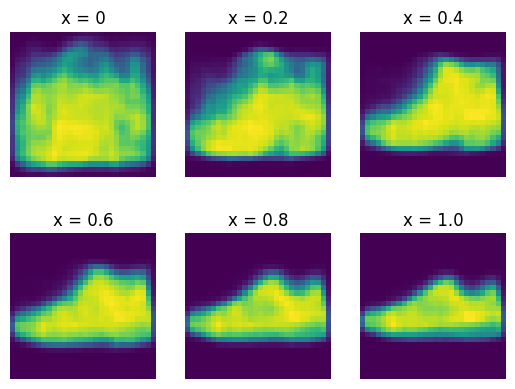

In [8]:
#%% Displaying Final Result
x = 0
j = 1
for i in range(1,7):

    plt.subplot(2,3,i)
    plt.axis('off')
    ZVector = x*AverageZ1 + (1-x)*AverageZ2 
    picture = vae.decoder(ZVector)
    newpic = np.reshape(picture[0], [28, 28])
    plt.imshow(newpic)
    plt.title("x = " + str(round(x,2)))
    
    x += 0.2